## Dacon 월간 데이콘 반도체 박막두께 분석 모델링 경진대회


In [1]:
import math
import time
from itertools import chain
import argparse

import numpy as np
import pandas as pd
from tqdm.auto import tqdm

import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import Optimizer
from torch.optim.lr_scheduler import LambdaLR

# 모델 학습을 위해 CUDA 환경 설정. : 지피유 설정
device = torch.device('cuda:0' if torch.cuda.is_available else 'cpu')

## 연습 

In [6]:
layers = [['layer_1','layer_2','layer_3','layer_4'], [str(i) for i in range(0, 226)]]
layers = list(chain(*layers))
layers

['layer_1',
 'layer_2',
 'layer_3',
 'layer_4',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '29',
 '30',
 '31',
 '32',
 '33',
 '34',
 '35',
 '36',
 '37',
 '38',
 '39',
 '40',
 '41',
 '42',
 '43',
 '44',
 '45',
 '46',
 '47',
 '48',
 '49',
 '50',
 '51',
 '52',
 '53',
 '54',
 '55',
 '56',
 '57',
 '58',
 '59',
 '60',
 '61',
 '62',
 '63',
 '64',
 '65',
 '66',
 '67',
 '68',
 '69',
 '70',
 '71',
 '72',
 '73',
 '74',
 '75',
 '76',
 '77',
 '78',
 '79',
 '80',
 '81',
 '82',
 '83',
 '84',
 '85',
 '86',
 '87',
 '88',
 '89',
 '90',
 '91',
 '92',
 '93',
 '94',
 '95',
 '96',
 '97',
 '98',
 '99',
 '100',
 '101',
 '102',
 '103',
 '104',
 '105',
 '106',
 '107',
 '108',
 '109',
 '110',
 '111',
 '112',
 '113',
 '114',
 '115',
 '116',
 '117',
 '118',
 '119',
 '120',
 '121',
 '122',
 '123',
 '124',
 '125',
 '126',
 '127',
 '128',
 '129',
 '130',
 '131',
 '132'

In [14]:
# test 파일 경로 및 test 데이터 로드
path_test = './input/test.csv'
class TestDataset(Dataset):
    def __init__(self, path_test):
        super(TestDataset, self).__init__()
        test = pd.read_csv(path_test)
        self.test_X = test.iloc[:,1:]
        self.tmp_x = self.test_X.values
    
    def __len__(self):
        return len(self.test_X)

    def __getitem__(self, idx):
        return torch.from_numpy(self.tmp_x)[idx]
    
test_data = TestDataset(path_test) # <__main__.TestDataset at 0x1f37cd22670>
test_loader = DataLoader(test_data, batch_size=10000,  num_workers=4) # <torch.utils.data.dataloader.DataLoader at 0x1f3715c9f40>
test_loader

## 2. 데이터 전처리
Data Cleansing & Pre-Processing

In [2]:
# 별도의 데이터 Pre-Processing 과정은 없고 모델 훈련시 검증을 위해 train 중 10000개를 validation 용으로 분리.
# 새로 만든 train.csv는 train1.csv, validation은 val.csv로 저장.
# dataframe.sample(frac=1) 을 통해 셔플.
path_train = './input/train.csv' # (810000,230)
path_test = './input/test.csv' # (10000,226)
layers = [['layer_1','layer_2','layer_3','layer_4'], [str(i) for i in range(0, 226)]]
layers = list(chain(*layers))

train = pd.read_csv(path_train)
train = train.sample(frac=1) # 랜덤추출
rows, cols = train.shape

train1 = train.iloc[:rows - 10000,:]
train1 = train1.values
train1 = pd.DataFrame(data=train1, columns=layers)
train1.to_csv('train1.csv', index_label='id')

val = train.iloc[rows - 10000:,:]
val = val.values
val = pd.DataFrame(data=val,columns=layers)
val.to_csv('val.csv', index_label='id')

In [2]:
a1=pd.DataFrame({'a':[1,2,3,4,5], 'b':[5,4,3,2,1]})
a12=a1.values
torch.from_numpy(a12)

tensor([[1, 5],
        [2, 4],
        [3, 3],
        [4, 2],
        [5, 1]])

In [4]:
train_loader = DataLoader(a12, batch_size=2,  num_workers=4)
len(train_loader)

In [ ]:
# 새로 만든 train/ val 모델 학습 데이터 경로를 설정.
train_path = './input/train1.csv'
val_path = './input/val.csv'

lr = 1e-03
adam_epsilon = 1e-06
epochs = 100
batch_size = 2048
warmup_step = 2000
loss_fn = nn.L1Loss() # MAE

# df -> array(df.values) -> tensor(torch.from_numpy(df.values))
class PandasDataset(Dataset):
    def __init__(self, path):
        super(PandasDataset, self).__init__()
        train = pd.read_csv(path).iloc[:,1:]
        self.train_X, self.train_Y = train.iloc[:,4:], train.iloc[:,0:4]
        self.tmp_x , self.tmp_y = self.train_X.values, self.train_Y.values
    
    def __len__(self):
        return len(self.train_X)

    def __getitem__(self, idx):
        return {
            'X':torch.from_numpy(self.tmp_x)[idx],
            'Y':torch.from_numpy(self.tmp_y)[idx]
        }
            
train_dataset = PandasDataset(train_path)
train_loader = DataLoader(train_dataset, batch_size=2048,  num_workers=4) # 0-2048, 2048-4096....7997952-800000, num_workers=사용할cpu개수

val_dataset = PandasDataset(val_path)
val_loader = DataLoader(val_dataset, batch_size=2048,  num_workers=4) # 0-2048, 2048-4096, 4096-6144, 6144-8192, 8192-10000 

## 3. 탐색적 자료분석
Exploratory Data Analysis

In [ ]:
# 4개의 layer_1, layer_2, layer_3, layer_4의 두께를 구하는 방법이라 마지막 Dense unit을 1로
# 해서 각각의 두께를 구하는 모델을 구성해보았으나 결과는 좋지 않음.
# 특별한 탐색적 자료 분석 없음.

## 4. 변수 선택 및 모델 구축
Feature Engineering & Initial Modeling

In [ ]:
"""
- Modeling

Learning rate : 다양한 learning rate 스케줄링. Warmup 스케줄링이 train, val loss 줄이는데 가장 효과적.
Activation function : ReLU, ELU, CeLU, GeLU 사용. 음의 영역에서는 0의 값을 가지는 relu 대신 ELU, CeLU, GeLU등을 사용. relu보다는 효과적.
Optimizer : adam, adamW.
Batch size : batch size는 10000으로 시작하였으나 10000보다 작은 값에서 효과적.
Hidden node, layer depth : node 수는 Nh = Ns/(a * (Ni + No))에 따라 초기 모델링에서는 약 2500개 정도로 하였으나 실험적으로 많은
node가 train, val loss 줄이는데 효과적.
(Nh : number of hidden , Ni : Number of input, No : Number of output, a : 2 - 10)
Loss funciotion : L1 Loss
BatchNorm : 모든 layer에 batchNorm 적용
MLP Model : 단순한 MLP 모델로는 한계를 느껴 MLP의 복잡성을 증가시키는 방향으로 설계
        (1) 노드 수를 증가시켰다 줄이는 방식(UP-block, DOWN-block)
        (2) Down-block에서 skip connection과 layer norm 적용
"""

In [ ]:
# 활성화 함수
class GELU(nn.Module):
    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(math.sqrt(2 / math.pi) * (x + 0.044715 * torch.pow(x, 3))))

## 연습

In [10]:
# requires_grad=True
x1 = torch.ones(2, 2)
print(x1)

x2 = torch.ones(2, 2, requires_grad = True)
print(x2) # requires_grad=True : 전파 과정을 수행 후, 해당 텐서의 변화도를 구할 수 있도록 합니다.

tensor([[1., 1.],
        [1., 1.]])
tensor([[1., 1.],
        [1., 1.]], requires_grad=True)


In [3]:
torch.ones(10).type

<function Tensor.type>

In [5]:
# 가중치 계산용(nn.Parameter())
# 레이어가 아니라 말 그대로 파라미터 값만을 가짐
nn.Parameter(torch.ones(10)).data.fill_(1.0)

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [19]:
torch.zeros(10)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [18]:
nn.Parameter(torch.zeros(10)).data.zero_()

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [14]:
# pow 함수
a = torch.tensor([1, 2, 3])
a.pow(2)

tensor([1, 4, 9])

In [6]:
# 계층정규화(평균,분산)
x= torch.tensor([0.01, 0.02, 0.03, 0.04, 0.05])
u = x.mean(-1, keepdim=True)
s = (x - u).pow(2).mean(-1, keepdim=True)
x = (x - u) / torch.sqrt(s + 1/100000)
u
s
x

tensor([-1.3801e+00, -6.9007e-01, -1.2853e-07,  6.9007e-01,  1.3801e+00])

In [12]:
# grad_fn=<AddBackward0>
nnParameter = nn.Parameter(torch.ones(5)) * x + nn.Parameter(torch.zeros(5))
print(nnParameter) # grad_fn에는 텐서가 어떤 연산을 하였는 지 연산 정보를 담고 있고, 이 정보는 역전파 과정에 사용될 예정입니다.

base = (torch.ones(5)) * x + (torch.zeros(5))
print(base)

tensor([-1.3801e+00, -6.9007e-01, -1.2853e-07,  6.9007e-01,  1.3801e+00],
       grad_fn=<AddBackward0>)
tensor([-1.3801e+00, -6.9007e-01, -1.2853e-07,  6.9007e-01,  1.3801e+00])


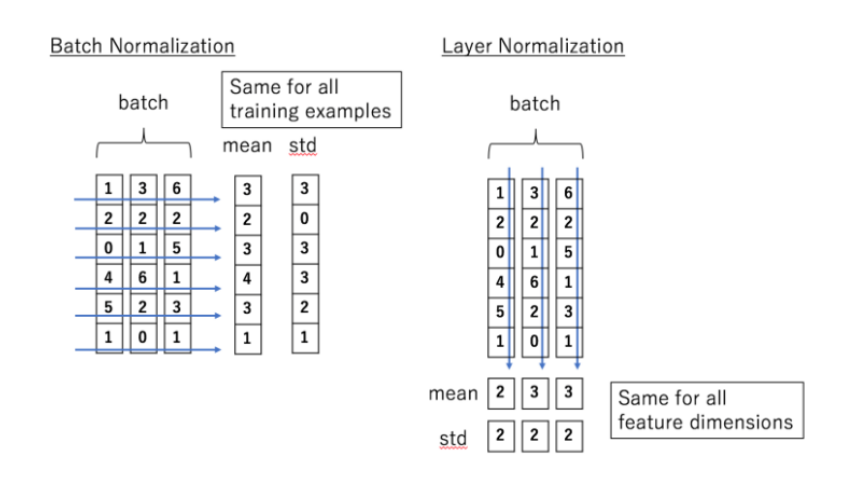

## 계층 정규화

In [ ]:
# 계층 정규화
class LayerNorm(nn.Module):
    def __init__(self, hidden_size, eps=1e-5):
        """Construct a layernorm module in the TF style (epsilon inside the square root).
        """
        super(LayerNorm, self).__init__()
        self.weight = nn.Parameter(torch.ones(hidden_size))
        self.bias = nn.Parameter(torch.zeros(hidden_size))
        self.variance_epsilon = eps

        self.init_weights()

    def init_weights(self):
        self.weight.data.fill_(1.0)
        self.bias.data.zero_()

    def forward(self, x):
        u = x.mean(-1, keepdim=True)
        s = (x - u).pow(2).mean(-1, keepdim=True)
        x = (x - u) / torch.sqrt(s + self.variance_epsilon) # 계층정규화 완료
        return self.weight * x + self.bias # wx+b

## 모델

In [ ]:
# MLP + (UP-block, DOWN-block) + Down-block에서 skip connection과 layer norm 적용
class skipConnectionModel(nn.Module):
    def __init__(self):
        super(skipConnectionModel, self).__init__()
        
        self.ln = LayerNorm(10000)
        self.ln1 = LayerNorm(7000)
        self.ln2 = LayerNorm(4000)
        self.ln3 = LayerNorm(2000)
        
        self.upblock1 = nn.Sequential(nn.Linear(226, 2000),GELU(),nn.BatchNorm1d(2000))
        self.upblock2 = nn.Sequential(nn.Linear(2000,4000),GELU(),nn.BatchNorm1d(4000))
        self.upblock3 = nn.Sequential(nn.Linear(4000,7000), GELU(),nn.BatchNorm1d(7000))
        self.upblock4 = nn.Sequential(nn.Linear(7000,10000),GELU(),nn.BatchNorm1d(10000))

        self.downblock1 = nn.Sequential(nn.Linear(10000, 7000),GELU(),nn.BatchNorm1d(7000))
        self.downblock2 = nn.Sequential(nn.Linear(7000, 4000),GELU(),nn.BatchNorm1d(4000))
        self.downblock3 = nn.Sequential(nn.Linear(4000, 2000),GELU(),nn.BatchNorm1d(2000))
        self.downblock4 = nn.Sequential(nn.Linear(2000, 300),GELU(),nn.BatchNorm1d(300))
        
        self.fclayer = nn.Sequential(nn.Linear(300,4))
        self.dropout = nn.Dropout(0.1)
        
    def forward(self, x):
        upblock1_out = self.upblock1(x)
        upblock2_out = self.upblock2(upblock1_out)
        upblock3_out = self.upblock3(upblock2_out)
        upblock4_out = self.upblock4(upblock3_out)
        
        downblock1_out = self.downblock1(self.ln(upblock4_out))
        skipblock1 = downblock1_out + upblock3_out
        downblock2_out = self.downblock2(self.ln1(skipblock1))
        skipblock2 = downblock2_out + upblock2_out
        downblock3_out = self.downblock3(self.ln2(skipblock2))
        skipblock3 = downblock3_out + upblock1_out
        downblock4_out = self.downblock4(self.ln3(skipblock3))
        
        output = self.fclayer(downblock4_out)
        
        return output

## 옵티마이저 스케쥴러

In [ ]:
# 옵티마이저 학습률=스케쥴러
def get_constant_schedule(optimizer, last_epoch=-1):
    """ Create a schedule with a constant learning rate.
    """
    return LambdaLR(optimizer, lambda _: 1, last_epoch=last_epoch)


def get_constant_schedule_with_warmup(optimizer, num_warmup_steps, last_epoch=-1):
    """ Create a schedule with a constant learning rate preceded by a warmup
    period during which the learning rate increases linearly between 0 and 1.
    """

    def lr_lambda(current_step):
        if current_step &lt; num_warmup_steps:
            return float(current_step) / float(max(1.0, num_warmup_steps))
        return 1.0

    return LambdaLR(optimizer, lr_lambda, last_epoch=last_epoch)


def get_linear_schedule_with_warmup(optimizer, num_warmup_steps, num_training_steps, last_epoch=-1):
    """ Create a schedule with a learning rate that decreases linearly after
    linearly increasing during a warmup period.
    """

    def lr_lambda(current_step):
        if current_step &lt; num_warmup_steps:
            return float(current_step) / float(max(1, num_warmup_steps))
        return max(
            0.0, float(num_training_steps - current_step) / float(max(1, num_training_steps - num_warmup_steps))
        )

    return LambdaLR(optimizer, lr_lambda, last_epoch)


def get_cosine_schedule_with_warmup(optimizer, num_warmup_steps, num_training_steps, num_cycles=0.5, last_epoch=-1):
    """ Create a schedule with a learning rate that decreases following the
    values of the cosine function between 0 and `pi * cycles` after a warmup
    period during which it increases linearly between 0 and 1.
    """

    def lr_lambda(current_step):
        if current_step &lt; num_warmup_steps:
            return float(current_step) / float(max(1, num_warmup_steps))
        progress = float(current_step - num_warmup_steps) / float(max(1, num_training_steps - num_warmup_steps))
        return max(0.0, 0.5 * (1.0 + math.cos(math.pi * float(num_cycles) * 2.0 * progress)))

    return LambdaLR(optimizer, lr_lambda, last_epoch)


def get_cosine_with_hard_restarts_schedule_with_warmup(
    optimizer, num_warmup_steps, num_training_steps, num_cycles=1.0, last_epoch=-1): # num_warmup_steps=2000

    """ Create a schedule with a learning rate that decreases following the
    values of the cosine function with several hard restarts, after a warmup
    period during which it increases linearly between 0 and 1.
    """

    def lr_lambda(current_step):
        if current_step &lt; num_warmup_steps:
            return float(current_step) / float(max(1, num_warmup_steps))
        progress = float(current_step - num_warmup_steps) / float(max(1, num_training_steps - num_warmup_steps))
        if progress &gt;= 1.0:
            return 0.0
        return max(0.0, 0.5 * (1.0 + math.cos(math.pi * ((float(num_cycles) * progress) % 1.0))))

    return LambdaLR(optimizer, lr_lambda, last_epoch)

## 옵티마이저


In [ ]:
# 옵티마이저
# optimizer = AdamW(optimizer_grouped_parameters, lr=1e-3, eps=1e-06)
class AdamW(Optimizer):
    """ Implements Adam algorithm with weight decay fix.
    Parameters:
        lr (float): learning rate. Default 1e-3.
        betas (tuple of 2 floats): Adams beta parameters (b1, b2). Default: (0.9, 0.999)
        eps (float): Adams epsilon. Default: 1e-6
        weight_decay (float): Weight decay. Default: 0.0
        correct_bias (bool): can be set to False to avoid correcting bias in Adam (e.g. like in Bert TF repository). Default True.
    """

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-6, weight_decay=0.0, correct_bias=True):
        # &lt; = < 마크업기반(html, xml)의 코드에서는 부등호(< , >)가 인식되지 않습니다.
        if lr &lt; 0.0: # lr<0.0 
            raise ValueError("Invalid learning rate: {} - should be &gt;= 0.0".format(lr))
        if not 0.0 &lt;= betas[0] &lt; 1.0: # 0<=0.9<1.0
            raise ValueError("Invalid beta parameter: {} - should be in [0.0, 1.0[".format(betas[0]))
        if not 0.0 &lt;= betas[1] &lt; 1.0: # 0<=0.99<1.0
            raise ValueError("Invalid beta parameter: {} - should be in [0.0, 1.0[".format(betas[1]))
        if not 0.0 &lt;= eps: #0<=1e-06
            raise ValueError("Invalid epsilon value: {} - should be &gt;= 0.0".format(eps))
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay, correct_bias=correct_bias)
        super().__init__(params, defaults)

    def step(self, closure=None):
        """Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group["params"]:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError("Adam does not support sparse gradients, please consider SparseAdam instead")

                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state["step"] = 0
                    # Exponential moving average of gradient value
                    state["exp_avg"] = torch.zeros_like(p.data)
                    # Exponential moving average of squared gradient values
                    state["exp_avg_sq"] = torch.zeros_like(p.data)

                exp_avg, exp_avg_sq = state["exp_avg"], state["exp_avg_sq"]
                beta1, beta2 = group["betas"]

                state["step"] += 1

                # Decay the first and second moment running average coefficient
                # In-place operations to update the averages at the same time
                exp_avg.mul_(beta1).add_(1.0 - beta1, grad)
                exp_avg_sq.mul_(beta2).addcmul_(1.0 - beta2, grad, grad)
                denom = exp_avg_sq.sqrt().add_(group["eps"])

                step_size = group["lr"]
                if group["correct_bias"]:  # No bias correction for Bert
                    bias_correction1 = 1.0 - beta1 ** state["step"]
                    bias_correction2 = 1.0 - beta2 ** state["step"]
                    step_size = step_size * math.sqrt(bias_correction2) / bias_correction1

                p.data.addcdiv_(-step_size, exp_avg, denom)

                # Just adding the square of the weights to the loss function is *not*
                # the correct way of using L2 regularization/weight decay with Adam,
                # since that will interact with the m and v parameters in strange ways.
                #
                # Instead we want to decay the weights in a manner that doesn't interact
                # with the m/v parameters. This is equivalent to adding the square
                # of the weights to the loss with plain (non-momentum) SGD.
                # Add weight decay at the end (fixed version)
                if group["weight_decay"] &gt; 0.0:
                    p.data.add_(-group["lr"] * group["weight_decay"], p.data)

        return loss

In [ ]:
model = skipConnectionModel()
model = model.to(device) # 모델을 GPU 메모리에 올림.

## 5. 모델 학습 및 검증
Model Tuning & Evaluation

In [6]:
no_decay = ["bias", "LayerNorm.weight"] # decay하지 않을 영역 지정.
model = nn.Linear(10,3)

optimizer_grouped_parameters = [
    {"params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
     "weight_decay": 0.0,},
    {"params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 
     "weight_decay": 0.0},
]
optimizer_grouped_parameters

[{'params': [Parameter containing:
   tensor([[-0.0212, -0.2701,  0.0072, -0.1194, -0.0752, -0.0926,  0.1966,  0.2385,
             0.3123,  0.2693],
           [-0.1057, -0.2142,  0.0351,  0.0620, -0.1357, -0.1117,  0.2934, -0.1177,
            -0.0729,  0.2771],
           [ 0.0601, -0.1083,  0.3017, -0.2169, -0.3026, -0.1122, -0.1028, -0.3035,
            -0.0647,  0.0645]], requires_grad=True)],
  'weight_decay': 0.0},
 {'params': [Parameter containing:
   tensor([-0.0300, -0.1544, -0.1807], requires_grad=True)],
  'weight_decay': 0.0}]

In [7]:
version = time.localtime()[3:5]
version

(15, 27)

In [ ]:
"""
모델 학습
"""

total_step = len(train_loader) * epochs # 800000/2048=390개의 배치*100 = total_iteration
print(f"Total step is....{total_step}") # 모델이 학습하는 전체 step 계산.

# 옵티마이저와 스케줄러의 파라미터들을 정의.

no_decay = ["bias", "LayerNorm.weight"] # decay하지 않을 영역 지정.
optimizer_grouped_parameters = [
    {"params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], # weight만 추출
     "weight_decay": 0.0,},
    {"params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], # bias만 추출
     "weight_decay": 0.0}]

optimizer = AdamW(optimizer_grouped_parameters, lr=1e-3, eps=1e-06)
scheduler = get_cosine_with_hard_restarts_schedule_with_warmup(
    optimizer, num_warmup_steps=warmup_step, num_training_steps=total_step
)

# train loss와 val loss 지정.
total_loss = 0.0
total_val_loss = 0.0

# 모델 이름을 위해서 변수 만듦.
version = time.localtime()[3:5] # (시간, 분)
curr_lr = lr

n_val_loss = 10000000. # 가장 낮은 validation loss를 저장하기 위해서 변수 설정.

for epoch in range(epochs): # 100
    total_loss = 0 
    total_val_loss = 0
    for i, data in enumerate(tqdm(train_loader, desc='*********Train mode*******')):  # 390
        # forward pass
        pred = model(data['X'].float().to(device))
        loss = loss_fn(pred, data['Y'].float().to(device))
        
        # backward pass
        optimizer.zero_grad() # optimizer 객체 사용해서 학습 가능한 가중치 변수에 대한 모든 변화도를 0으로 만듦
        loss.backward() 
        optimizer.step() # update optimizer params
        scheduler.step() # update scheduler params
        
        total_loss += loss.item()
        
    train_loss = total_loss / len(train_loader)
    print ("Epoch [{}/{}], Train Loss: {:.4f}".format(epoch+1, epochs, train_loss))

    # evaluation
    # validation 데이터를 부르고 epoch 마다 학습된 모델을 부르고 평가.
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(tqdm(val_loader, desc='*********Evaluation mode*******')):
            pred = model(data['X'].float().to(device))
            loss_val = loss_fn(pred, data['Y'].float().to(device))
            
            total_val_loss += loss_val.item()
    val_loss = total_val_loss / len(val_loader)
    print ("Epoch [{}/{}], Eval Loss: {:.4f}".format(epoch+1, epochs, val_loss))
    
    # best model을 저장.
    if val_loss &lt; n_val_loss:
        n_val_loss = val_loss
        torch.save(model.state_dict(), f'test_{version}_{lr}_{epochs}.pth')
        print("Best Model saved......")

In [ ]:
"""
모델 테스트
"""

test_model = skipConnectionModel()

# test 파일 경로 및 test 데이터 로드
path_test = 'test.csv'
class TestDataset(Dataset):
    def __init__(self, path_test):
        super(TestDataset, self).__init__()
        test = pd.read_csv(path_test)
        self.test_X = test.iloc[:,1:]
        self.tmp_x = self.test_X.values
    
    def __len__(self):
        return len(self.test_X)

    def __getitem__(self, idx):
        return torch.from_numpy(self.tmp_x)[idx]
    
test_data = TestDataset(path_test) # <__main__.TestDataset at 0x1f37cd22670>
test_loader = DataLoader(test_data, batch_size=10000,  num_workers=4) # <torch.utils.data.dataloader.DataLoader at 0x1f3715c9f40>

# 모델에 학습된 가중치를 업로드.
weights = torch.load(f'test_{version}_{lr}_{epochs}.pth', map_location='cuda:0')
test_model.load_state_dict(weights) # 가중치 업로드
test_model = test_model.to(device)

# 해당 모델의 모든 레이어가 evaluation(inference) mode
# == 학습할 때만 필요한 Dropout, Batchnorm등의 기능을 비활성화 시킨다
test_model.eval()

with torch.no_grad(): # autograd engine(gradient를 계산해주는 context)을 비활성화시켜 메모리를 줄어주고 연산속도를 증가
    for data in test_loader:
        data = data.to(device)
        outputs = test_model(data.float())
pred_test = outputs

sample_sub = pd.read_csv('sample_submission.csv', index_col=0)
layers = ['layer_1','layer_2','layer_3','layer_4']
submission = sample_sub.values + pred_test.cpu().numpy()

submission = pd.DataFrame(data=submission, columns=layers)
submission.to_csv(f'test_{version}_{lr}_{epochs}.csv', index_label='id')

In [19]:
sample_sub = pd.read_csv('./input/sample_submission.csv', index_col=0)
sample_sub.values

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [ ]:
# + Self evaluation and Ensemble
# Dacon의 제출하기를 통해 측정한 mae값 중 가장 낮은 mae csv 파일과 다른 파라미터 적용으로 훈련한 모델과 mae 비교를 통해
# 대략적인 test mae를 예상한 뒤 제출하기 하여 3번 제출할 수 있는 기회를 최대한 살림.
# 다양한 파라미터 적용을 통한 모델들을 아래의 en함수를 통해 합친 뒤 평균을 구하여 제출
# (추가하는 csv 파일의 수에 따라 en함수의 함수가 받는 csv 파일 개수 증가 및 코드 수정 필요.)
def mae(best_path, my_path):
    best = pd.read_csv(best_path)
    best_value = best.iloc[:,1:].values
    value = pd.read_csv(my_path)
    my_value = value.iloc[:,1:].values
    abs_value = abs(best_value - my_value)
    size = abs_value.shape
    return sum(sum(abs_value) / (size[0]*size[1]))

def en(best_path, my_path):
    best = pd.read_csv(best_path)
    best_value = best.iloc[:,1:].values
    value = pd.read_csv(my_path)
    my_value = value.iloc[:,1:].values
    return (my_value + best_value)/2